In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.optimizers import Adam

from matplotlib import pyplot as plt
from wasserstein_loss import wasserstein_generator_loss, wasserstein_discriminator_loss
from tabular_wgan_gp import tabularWGANGP
from tabular_discriminator import build_discriminator
from tabular_generator import build_generator

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Building the model

In [3]:
latent_dim = 32
out_shape = 8
num_classes = 2

In [4]:
generator = build_generator(latent_dim = latent_dim, num_classes = num_classes, out_shape = out_shape, layers_dim=[128,256,512])

In [5]:
discriminator = build_discriminator(out_shape = out_shape, num_classes = num_classes, layers_dim=[512,256,128])

In [6]:
model = tabularWGANGP(generator, discriminator, latent_dim = latent_dim, out_shape = out_shape,
                     num_classes = num_classes, d_steps=10)
model.compile(    
    discriminator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    generator_optimizer=Adam(learning_rate=2e-4,beta_1=0.5,beta_2=0.9),
    discriminator_loss = wasserstein_discriminator_loss,
    generator_loss = wasserstein_generator_loss
)

## Reading and preprocessing the data

In [7]:
df = pd.read_csv('data/original/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
y = df["Outcome"].values
x = df.drop(["Outcome"],1)
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
# setting up constants
epochs = 100
batch_size = 32

In [10]:
y_train = keras.utils.to_categorical(y_train,num_classes)
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset = dataset.shuffle(buffer_size=128).batch(batch_size)

In [11]:
model.fit(dataset, epochs = epochs, batch_size=batch_size)

Epoch 1/100
20/20 [==============================] - 8s 44ms/step - g_loss: -0.0100 - d_loss: 2.1976
Epoch 2/100
20/20 [==============================] - 1s 38ms/step - g_loss: -0.0091 - d_loss: -1.0324
Epoch 3/100
20/20 [==============================] - 1s 40ms/step - g_loss: 0.0131 - d_loss: -0.9500
Epoch 4/100
20/20 [==============================] - 1s 35ms/step - g_loss: 0.0899 - d_loss: -0.8306
Epoch 5/100
20/20 [==============================] - 1s 39ms/step - g_loss: 0.9690 - d_loss: -0.7409
Epoch 6/100
20/20 [==============================] - 1s 37ms/step - g_loss: 1.8409 - d_loss: -0.7756
Epoch 7/100
20/20 [==============================] - 1s 36ms/step - g_loss: 2.3648 - d_loss: -0.8429
Epoch 8/100
20/20 [==============================] - 1s 37ms/step - g_loss: 3.1841 - d_loss: -0.7682
Epoch 9/100
20/20 [==============================] - 1s 36ms/step - g_loss: 3.5435 - d_loss: -0.7093
Epoch 10/100
20/20 [==============================] - 1s 38ms/step - g_loss: 4.2715 - d_lo

## Evaluating the results

In [12]:
y_train = np.argmax(y_train, axis = -1)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        94
           1       0.74      0.62      0.67        60

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.76      0.77      0.76       154



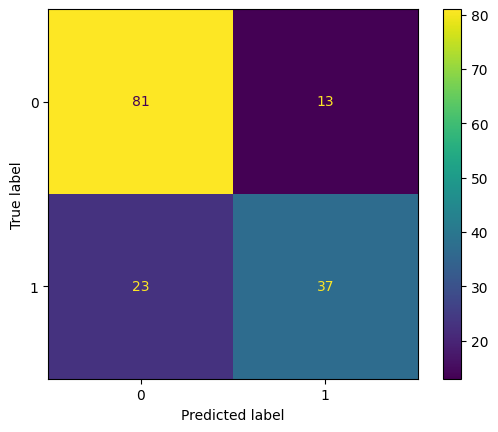

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix

# first train a random forest classifier on the original data
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf, x_test, y_test)
plt.show()

In [14]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [15]:
# generate data using trained model
noise = np.random.normal(0, 1, (400, latent_dim))
sampled_labels = np.zeros(400).reshape(-1, 1)
sampled_labels = keras.utils.to_categorical(sampled_labels,num_classes)

gen_samples = model.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('Outcome',1).columns)

noise_2 = np.random.normal(0, 1, (212, latent_dim))
sampled_labels_2 = np.ones(212).reshape(-1, 1)
sampled_labels_2 = keras.utils.to_categorical(sampled_labels_2,2)

gen_samples_2 = model.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('Outcome',1).columns)

gen_df_2['Outcome'] = 1
gen_df['Outcome']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

x_train_2 = df_gan.drop('Outcome', 1)
y_train_2 = df_gan['Outcome'].values

7/7 [==============================] - 0s 2ms/step


In [16]:
x_train_2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.709161,-0.953081,0.329987,0.908326,-0.454819,0.789503,-0.467240,0.212557
1,-0.585529,-0.770299,0.521876,0.883584,0.503233,0.548807,-0.847864,-0.490982
2,0.749084,-0.047936,0.079309,0.314855,-0.153893,-0.306249,-0.550605,-0.743699
3,0.165887,-0.267524,-0.788970,-0.429934,-0.829750,-0.054381,0.814305,-0.165414
4,-0.647218,-0.608170,0.578767,0.968224,0.643607,0.728364,-0.880592,-0.796869


              precision    recall  f1-score   support

           0       0.82      0.80      0.81        94
           1       0.69      0.72      0.70        60

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.76       154
weighted avg       0.77      0.77      0.77       154



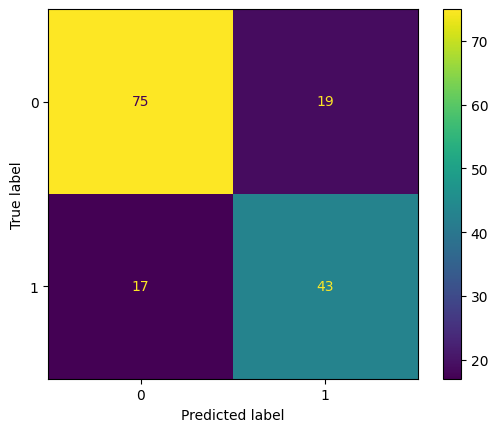

In [17]:
# now train a different instance of random forest classifier with the same parameters on generated data
rf1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf1.fit(x_train_2,y_train_2)

y_pred = rf1.predict(x_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf1, x_test, y_test)
plt.show()

## Disctance measurement for generated data

In [18]:
generated = scaler.inverse_transform(df_gan.drop("Outcome",1))
generated_df = pd.DataFrame(data=generated,columns = df.drop("Outcome",1).columns)
generated_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.457034,90.441895,75.488480,35.016830,27.418501,38.213093,0.317167,35.738976
1,1.873352,96.282082,79.200211,34.622402,137.756302,36.316639,0.191138,27.470583
2,6.367506,119.362877,70.639557,25.555824,62.075771,29.579638,0.289564,24.500511
3,4.403657,112.346664,53.844265,13.682528,-15.761945,31.564110,0.741503,31.296848
4,1.665619,101.462402,80.300674,35.971710,153.923065,37.731377,0.180301,23.875624


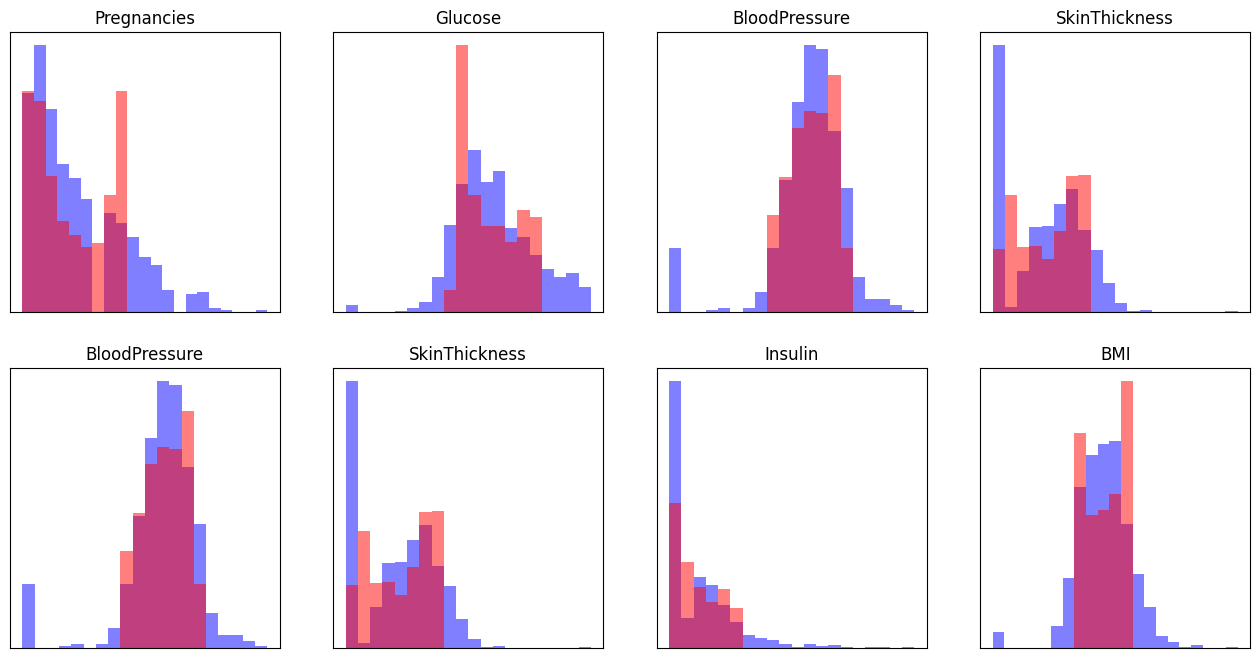

In [19]:
from utils import build_hist
build_hist(df,generated_df,2,4,df.drop("Outcome",1).columns,figsize=(16,8))

In [21]:
print(generated_df.mean())
print(generated_df.std())

Pregnancies                   3.531879
Glucose                     116.563499
BloodPressure                70.775764
SkinThickness                21.940710
Insulin                      62.949997
BMI                          32.360699
DiabetesPedigreeFunction      0.423439
Age                          31.435770
dtype: float32
Pregnancies                  2.488604
Glucose                     21.907347
BloodPressure               10.359290
SkinThickness               11.670437
Insulin                     76.353142
BMI                          5.309234
DiabetesPedigreeFunction     0.219546
Age                          8.837710
dtype: float32
